### Importing Necessary Libraries

In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

### Fetching and Preprocessing Image

In [ ]:
def fetch_and_preprocess_image(image_url, max_dimension=400, target_shape=None):
    # download image from url and apply standard preprocessing
    headers = {'User-Agent': 'Mozilla/5.0'}  # set headers to avoid request block
    response = requests.get(image_url, headers=headers)

    if response.status_code != 200:
        raise Exception(f"failed to fetch image. status code: {response.status_code}")

    img = Image.open(BytesIO(response.content)).convert('RGB')  # open image and convert to rgb
    resize_size = min(max(img.size), max_dimension)  # choose resize based on max dimension

    if target_shape is not None:
        resize_size = target_shape  # override size if shape is provided

    preprocessing_steps = transforms.Compose([
        transforms.Resize(resize_size),  # resize image
        transforms.ToTensor(),  # convert to tensor
        transforms.Normalize((0.485, 0.456, 0.406),  # normalize using imagenet mean
                             (0.229, 0.224, 0.225))  # and std deviation
    ])

    img_tensor = preprocessing_steps(img)[:3, :, :].unsqueeze(0)  # apply transforms and add batch dim
    return img_tensor

### Converting Tensor to Displayable Image

In [13]:
def tensor_to_image(img_tensor):
    # convert normalized tensor back to displayable image
    img = img_tensor.to('cpu').clone().detach()  # move to cpu and detach from graph
    img = img.numpy().squeeze()  # convert to numpy and remove batch dim
    img = img.transpose(1, 2, 0)  # reorder dimensions to h x w x c
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # denormalize
    img = img.clip(0, 1)  # clip to valid pixel range
    return img

### Extracting Features from Specific Layers of the Model

In [14]:
def extract_layer_features(input_image, cnn_model, selected_layers=None):
    # extract features from specific layers of the model
    if selected_layers is None:
        # default layer mapping for vgg19
        selected_layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'content_layer',  # usually used for content representation
            '28': 'conv5_1'
        }

    extracted_features = {}
    output = input_image

    # iterate over model layers and extract outputs at selected layers
    for layer_index, layer in cnn_model._modules.items():
        output = layer(output)
        if layer_index in selected_layers:
            layer_name = selected_layers[layer_index]
            extracted_features[layer_name] = output

    return extracted_features

### Computing the Gram Matrix from Feature Map

In [15]:
def compute_gram_matrix(feature_map):
    # compute the gram matrix from feature map
    _, depth, height, width = feature_map.size()  # get the dimensions of the feature map
    feature_map = feature_map.view(depth, height * width)  # flatten the spatial dimensions
    return torch.mm(feature_map, feature_map.t())  # compute the gram matrix (outer product)

### Converting Tensor to Displayable Image

In [16]:
def tensor_to_image_display(tensor):
    # convert tensor to a displayable image format
    image = tensor.to('cpu').clone().detach()  # move tensor to cpu and detach it from the graph
    image = image.numpy().squeeze()  # convert to numpy and remove the batch dimension
    image = image.transpose(1, 2, 0)  # change tensor shape to height x width x channels
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # de-normalize
    image = image.clip(0, 1)  # ensure pixel values are within valid range [0, 1]
    return image

### Performing Style Transfer


In [17]:
def style_transfer(content_image_url, style_image_url, num_steps, save_interval, model):
    # perform style transfer between content and style images
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # check if cuda is available
    vgg = model  # pre-trained VGG model
    content_image = fetch_and_preprocess_image(content_image_url).to(device)  # load and preprocess content image
    style_image = fetch_and_preprocess_image(style_image_url, shape=content_image.shape[-2:]).to(device)  # load and preprocess style image

    # extract features from both content and style images
    content_features = extract_layer_features(content_image, vgg)
    style_features = extract_layer_features(style_image, vgg)

    # compute gram matrices for style features
    style_grams = {
        layer: compute_gram_matrix(style_features[layer]) for layer in style_features
    }

    # initialize the target image for optimization
    target_image = content_image.clone().requires_grad_(True).to(device)

    # predefined weights for style layers
    style_layer_weights = {
        'conv1_1': 1.0,
        'conv2_1': 0.8,
        'conv3_1': 0.5,
        'conv4_1': 0.3,
        'conv5_1': 0.1
    }

    # hyperparameters for the loss function
    content_weight = 1
    style_weight = 1e6
    optimizer = optim.Adam([target_image], lr=0.003)  # optimization setup

    for step in range(1, num_steps + 1):
        # extract features of the target image
        target_features = extract_layer_features(target_image, vgg)

        # calculate the content loss (difference between target and content image)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

        # calculate the style loss (difference between target and style image)
        style_loss = 0
        for layer in style_layer_weights:
            target_feature = target_features[layer]
            _, d, h, w = target_feature.shape

            target_gram = compute_gram_matrix(target_feature)  # gram matrix of the target image
            style_gram = style_grams[layer]  # gram matrix of the style image

            # calculate style loss for each layer and accumulate
            layer_style_loss = style_layer_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
            style_loss += layer_style_loss / (d * h * w)

        # total loss is the weighted sum of content and style losses
        total_loss = ((content_weight * content_loss) + (style_weight * style_loss)) / (content_weight + style_weight)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % save_interval == 0:
            print(f'Step {step}/{num_steps}, Total Loss: {total_loss.item():.4f}')

    return content_image, style_image, target_image  # return original content, style, and the generated image

### Setting Up the Device and VGG Model


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # choose device (cuda if available)

# load pre-trained VGG19 model and keep only the feature layers (excluding classifier)
vgg_model = models.vgg19(pretrained=True).features

# freeze model parameters to avoid updating them during training
for param in vgg_model.parameters():
    param.requires_grad_(False)

# move the model to the selected device (GPU or CPU)
vgg_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Executing Style Transfer on Content and Style Images


In [19]:
# Perform style transfer on content and style images
content_image, style_image, generated_image = style_transfer(
    'https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg',  # URL of the content image
    'https://m.media-amazon.com/images/I/71N9bGfQSfL.jpg',  # URL of the style image
    6000,  # Number of optimization steps for style transfer
    1000,  # Interval to display loss during the optimization process
    vgg_model  # Pre-trained VGG model
)

Step 1000/6000, Total Loss: 38.0564
Step 2000/6000, Total Loss: 18.7161
Step 3000/6000, Total Loss: 11.4165
Step 4000/6000, Total Loss: 7.9840
Step 5000/6000, Total Loss: 5.5361
Step 6000/6000, Total Loss: 3.6946


### Displaying Content, Style, and Generated Images


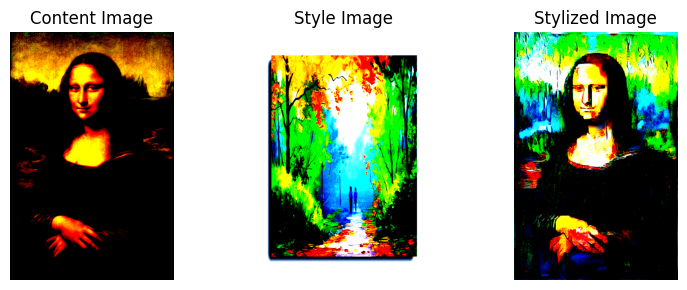

In [20]:
# move the images to CPU and remove batch dimension (squeeze)
content_image = content_image.cpu().squeeze(0)
style_image = style_image.cpu().squeeze(0)
generated_image = generated_image.cpu().squeeze(0)

def tensor_to_image(tensor):
    # convert tensor to displayable image (H x W x C format)
    image = tensor.clone().detach()
    image = image.permute(1, 2, 0)  # change shape from C x H x W to H x W x C
    image = image.clamp(0, 1)  # clip values to be in [0, 1] range
    return image

# plot the images: content, style, and generated
plt.figure(figsize=(8, 3))

# content image
plt.subplot(1, 3, 1)
plt.imshow(tensor_to_image(content_image))
plt.title('Content Image')
plt.axis('off')

# style image
plt.subplot(1, 3, 2)
plt.imshow(tensor_to_image(style_image))
plt.title('Style Image')
plt.axis('off')

# generated stylized image
plt.subplot(1, 3, 3)
plt.imshow(tensor_to_image(generated_image))
plt.title('Stylized Image')
plt.axis('off')

plt.tight_layout()
plt.show()